In [1]:
from pytorch_grad_cam import ScoreCAM, GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import yaml
from torch.utils.data import DataLoader

In [2]:
# 참고용 레이블
labels = {
    0:"Aerosol", 
    1:"Alcohol", 
    2:"Awl",
    3:"Axe", 
    4:"Bat",
    5:"Battery", 
    6:"Bullet", 
    7:"Firecracker", 
    8:"Gun", 
    9:"GunParts",
    10:"Hammer", 
    11:"HandCuffs", 
    12:"HDD", 
    13:"Knife",
    14:"Laptop",
    15:"Lighter",
    16:"Liquid", 
    17:"Match",
    18:"MetalPipe", 
    19:"NailClippers", 
    20:"PrtableGas", 
    21:"Saw", 
    22:"Scissors", 
    23:"Screwdriver", 
    24:"SmartPhone", 
    25:"SolidFuel", 
    26:"Spanner", 
    27:"SSD",
    28:"SupplymentaryBattery", 
    29:"TabletPC",
    30:"Thinner", 
    31:"USB",
    32:"ZippoOil", 
    33:"Plier", 
    34:"Chisel", 
    35:"Electronic cigarettes", 
    36:"Electronic cigarettes(Liquid)", 
    37:"Throwing Knife", 
}


In [3]:
with open('/opt/ml/finalproject/multilabel/Q2L/configs/train.yaml') as f:
        config_train = yaml.load(f, Loader=yaml.FullLoader)

In [11]:
import sys
sys.path.append('/opt/ml/finalproject/multilabel/baseline')
from dataset import CustomDataLoader
import albumentations as A

train_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
    A.pytorch.ToTensorV2()
])

import albumentations as A
train_dataset = CustomDataLoader(
        image_dir="/opt/ml/finalproject/data/",
        data_dir=config_train['train_path'], 
        mode="train", 
        transform= train_transform
    )


# data_loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config_train['batch_size'],
    num_workers=config_train['workers'],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [13]:
first_batch = next(iter(train_loader))
print(first_batch[0][0, :, :, :].shape)


torch.Size([3, 512, 512])


In [14]:
from model import ResNet101
import torch

#change pth dir
model = ResNet101(38)
checkpoint = torch.load('pth_dir', map_location=torch.device('cuda'))
model.load_state_dict(checkpoint)


FileNotFoundError: [Errno 2] No such file or directory: 'pth_dir'

In [ ]:
cam = EigenCAM(model,[model.backbone.layer4[-1]], use_cuda=True)

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [ ]:
viz = []
from tqdm import tqdm
for i in tqdm(range(38)):
    grayscale_cam = cam(input_tensor=first_batch[0][0, :, :, :].unsqueeze(0), target_category=i)
    grayscale_cam = grayscale_cam[0, :]

    denorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
    im_tensor = first_batch[0][0, :, :, :].clone()
    img = denorm(im_tensor)
    img2 = img.permute(1, 2, 0) * 255
    viz.append(show_cam_on_image(img2.numpy(), grayscale_cam, use_rgb=True))

100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


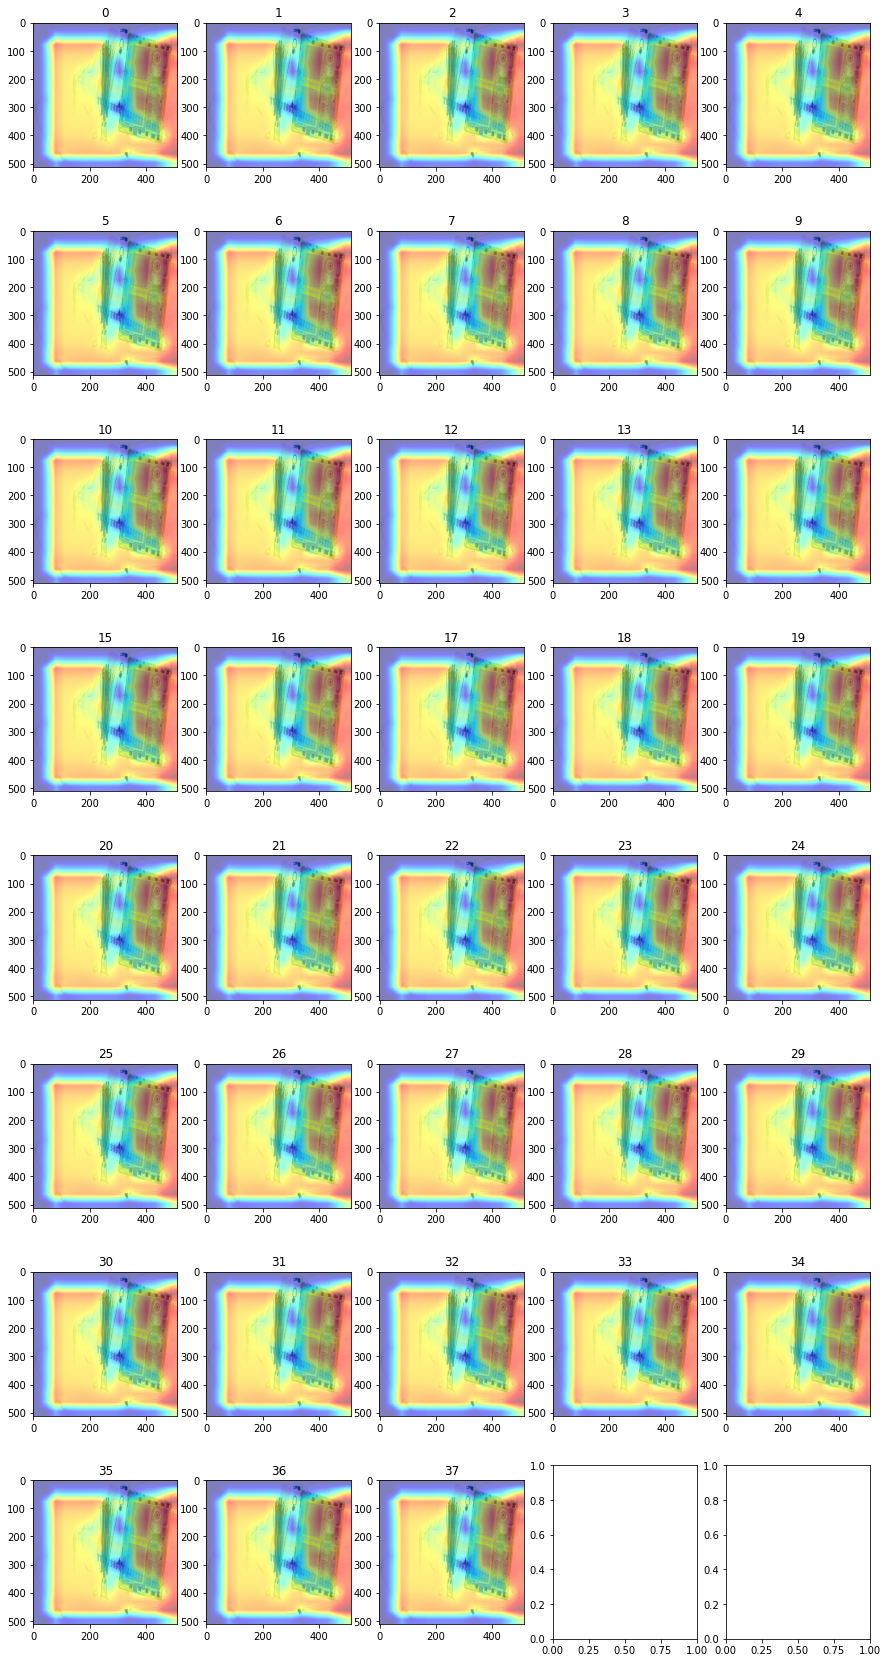

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

#변경사항: 각 레이블 별 cam을 볼 수 있도록 변경
fig, axes = plt.subplots(nrows = 8, ncols = 5, figsize = (15, 30))
for id, (v, ax) in enumerate(zip(viz, axes.ravel())):
    ax.imshow(v)
    ax.set_title(labels[id])

plt.show()    
